In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import textwrap
from datetime import datetime,date
import warnings
from openpyxl import Workbook
warnings.filterwarnings("ignore")
import os

path_dgsante_project = 'C:/Users/amedina/OneDrive - Tecnológica de Alimentos S.A/Proyectos/dgsante'
inicio_tem_2022_1 = '2022-04-01'
fin_tem_2022_1 = '2022-07-31'

inicio_tem_2022_2 = '2022-11-23'
fin_tem_2022_2 = '2023-01-31'

In [2]:
def barplot_df(x,y,df,title):
    ax = sns.barplot(x=x,y=y,data=df)
    plt.title(title,fontsize=10)
    ax.bar_label(ax.containers[0])

def barplot_df_hue(x,y,hue,df,title):
    plt.figure(figsize=(10,10))
    ax = sns.barplot(x=x,y=y,hue=hue,data=df)
    plt.title(title,fontsize=10)
    for i in ax.containers:
        ax.bar_label(i,)
    
def boxplot_df(df,x,title):
    sns.boxplot(x=df[x]).set(title=title)
    
def piechart_percentage(df,title):
    labels = ['Inconforme','Conforme']
    colors = ('#bb2124','#5bc0de')
    plt.title(title,fontsize=10)
    plt.pie(df['Percentage'], labels=labels, colors=colors,autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')  
    plt.show()
    
def histplot_df_hue(df,x,hue,title):
    sns.histplot(df, x=x, hue=hue).set(title=title)
    
def histplot_df(df,x,title):
    sns.histplot(df, x=x,binwidth=3).set(title=title)
    
def countplot_percentage_hue(x,hue,df,title):
    df = df.groupby(x)[hue].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('percent').reset_index()
    
    g = sns.catplot(x=x,y='percent',hue=hue, kind='bar',data=df)
 
    plt.title(title, fontsize=10)
    for p in g.ax.patches:
        percentage = str((p.get_height().round()).astype(int)) + '%'
        x = p.get_x()+ 0.015
        y = p.get_height() * 1.02
        g.ax.annotate(percentage, (x, y),color='black', rotation='horizontal')
    plt.show()

In [3]:
def solve_datetime_sheets(datetime_s):
 
    year = (datetime_s).year #2022
    mon = (datetime_s).month #02
    day = (datetime_s).day  #12
    hour = (datetime_s).hour
    minute = (datetime_s).minute
    second = (datetime_s).second

    if (( day == 12) & (mon < day)  ):
        return datetime(year, day, mon,hour,minute,second)
    else:
        return datetime(year, mon, day,hour,minute,second)
    
def values_total(x,df):
    all = df[x].value_counts()
    percentage = all/len(df)*100
    df_mv = pd.DataFrame(data=[all,percentage])
    df_mv = df_mv.T
    df_mv.columns = ['Values','Percentage']
    return df_mv.sort_index()    

def identify_outliers(df):
  for i in df.describe().columns:
    Q1 = df.describe().at['25%', i]
    Q3 = df.describe().at['75%', i]
    IQR = Q3-Q1
    LTV = Q1 - 1.5 * IQR 
    UTV = Q3 + 1.5 * IQR 
    print('Nombre de Columna                                         :', i)
    print('Rango Intercuartil IQR                                    :', IQR)
    print('Limite Inferior                                           :', LTV)
    print('Limite Superior                                           :', UTV)
    print('Número de outliers por debajo del bigote inferior         :', df[df[i] < LTV][i].count())
    print('Número de outliers por encima del bigote superior         :', df[df[i] > UTV][i].count())
    print('Total de Ourliers                                         :', (df[df[i] < LTV][i].count()) + (df[df[i] > UTV][i].count()))
    print('\n')
    
def select_values_outliers(df):
  for i in df.describe().columns:
    Q1 = df.describe().at['25%', i]
    Q3 = df.describe().at['75%', i]
    IQR = Q3-Q1
    LTV = Q1 - 1.5 * IQR 
    UTV = Q3 + 1.5 * IQR 
    return LTV,UTV

In [4]:

# QUERY MAREAS ACODERE
driver = '{ODBC Driver 17 for SQL Server}'
server = 'srv-db-east-repl001.database.windows.net'
database_name = 'db_cfa_prd01'
user = 'userpowerbi'
password = '#p4ssw0rdp0w3rb1#'

connection_string = textwrap.dedent('''
    Driver={driver};
    Server={server};
    Database={database_name};
    Uid={user};
    Pwd={password};
    Encrypt=yes;
    TrustServerCertificate=no;
'''.format(driver=driver,server=server,database_name=database_name,user=user,password=password))

conn = pyodbc.connect(connection_string)

cursor = conn.cursor()

cursor.execute("""SELECT marea_id as MAREA,
       DATEADD(HOUR,-5,acodera_chata) AS ACODERA,
	     DATEADD(HOUR,-5,inicio_succion) AS INICIO_SUCCION,
	   DATEADD(HOUR,-5,termino_succion) AS TERMINO_SUCCION,
	   CASE WHEN DATEADD(HOUR,-5,acodera_chata) >= '{a}' AND DATEADD(HOUR,-5,acodera_chata) <= '{b}' THEN '2022 - I' 
	   WHEN DATEADD(HOUR,-5,acodera_chata) >= '{c}' AND DATEADD(HOUR,-5,acodera_chata) <= '{d}' THEN '2022 - II'
	   ELSE 'OTHER' END AS TEMPORADA
       FROM dbo.MareasAcodere
       WHERE DATEADD(HOUR,-5,acodera_chata) >= '{inicio}'""".format(a=inicio_tem_2022_1,b=fin_tem_2022_1,c=inicio_tem_2022_2,d=fin_tem_2022_2,inicio=inicio_tem_2022_1))

df_mareas = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description])
df_mareas['MAREA'] = pd.to_numeric(df_mareas['MAREA'])
df_mareas = df_mareas[~df_mareas['MAREA'].duplicated()]
cursor.close()

driver = '{ODBC Driver 17 for SQL Server}'
server = 'srv-db-east-us-tasa-his-02.database.windows.net'
database_name = 'db_bi_production_prd'
user = 'userpowerbi'
password = '#p4ssw0rdp0w3rb1#'

connection_string = textwrap.dedent('''
    Driver={driver};
    Server={server};
    Database={database_name};
    Uid={user};
    Pwd={password};
    Encrypt=yes;
    TrustServerCertificate=no;
'''.format(driver=driver,server=server,database_name=database_name,user=user,password=password))

conn = pyodbc.connect(connection_string)

cursor = conn.cursor()

cursor.execute("""SELECT 
        MAREA, 
        PLANTA,
        CAST(F_ARRIB AS DATETIME) + CAST(H_ARRIB AS DATETIME) AS FECHA_ARRIBO,
        CASE WHEN D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_INICI AS DATETIME) ELSE CAST(F_ARRIB AS DATETIME) + CAST(D_INICI AS DATETIME) END AS INICIO_DESCARGA,
        CASE WHEN D_FINAL < D_INICI AND D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,2,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME) 
         WHEN D_FINAL < D_INICI AND D_INICI > H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME) 
         WHEN D_FINAL > D_INICI AND D_INICI < H_ARRIB THEN CAST(DATEADD(DAY,1,F_ARRIB) AS DATETIME) + CAST(D_FINAL AS DATETIME)
         ELSE CAST(F_ARRIB AS DATETIME) + CAST(D_FINAL AS DATETIME) END AS FIN_DESCARGA
        FROM sap.ZQM_DESC_MP_CHI
        WHERE FECHA >= '{inicio}' AND MAREA <> 0""".format(inicio=inicio_tem_2022_1))

df_chi = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description])
df_chi['MAREA'] = pd.to_numeric(df_chi['MAREA'])
df_chi['PLANTA'] = df_chi['PLANTA'].str.split(' ').str[0].str.upper()
df_chi = df_chi[~df_chi['MAREA'].duplicated()]
cursor.close()

df_bitacora = pd.merge(df_mareas,df_chi, on=["MAREA"],how='inner')

# FORMS QUERY
df_forms_dgsante = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRsp2vmTU-CMxMpwWAui3SohhzlVSfQF-s5vGO3H8tkmFPjrKZk8ZZ47xflO-YQf4uMIkvVTiEX3aAe/pub?gid=0&single=true&output=csv')

df_forms_dgsante['1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS'] = pd.to_datetime(df_forms_dgsante['1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS'])
df_forms_dgsante['2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS'] = pd.to_datetime(df_forms_dgsante['2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS'])

df_forms_dgsante.rename(columns={'1 - INICIO DE ANÁLISIS 1 -INICIO DE ANÁLISIS':'INICIO_ANALISIS'},inplace = True)
df_forms_dgsante.rename(columns={'2 - FIN DE ANÁLISIS 2 - FIN DE ANÁLISIS':'FIN_ANALISIS'},inplace = True)

df_forms_dgsante['INICIO_ANALISIS'] = df_forms_dgsante['INICIO_ANALISIS'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))
df_forms_dgsante['FIN_ANALISIS'] = df_forms_dgsante['FIN_ANALISIS'].apply(lambda x:  solve_datetime_sheets(x.to_pydatetime()))

df_forms_dgsante = df_forms_dgsante[~df_forms_dgsante['MAREA'].duplicated()]

df_tasa = pd.merge(df_bitacora,df_forms_dgsante, on=["MAREA","PLANTA"],how='left')
df_tasa = df_tasa[~df_tasa['INICIO_SUCCION'].isnull()]
df_tasa = df_tasa[df_tasa['TEMPORADA']!='OTHER']

df_export = df_tasa.sort_values(by='ACODERA', ascending=False)
df_export.to_excel(path_dgsante_project+"/consolidated_data.xlsx",index=False)

# RESULTADOS DATA DGSANTE - MIO - CHI

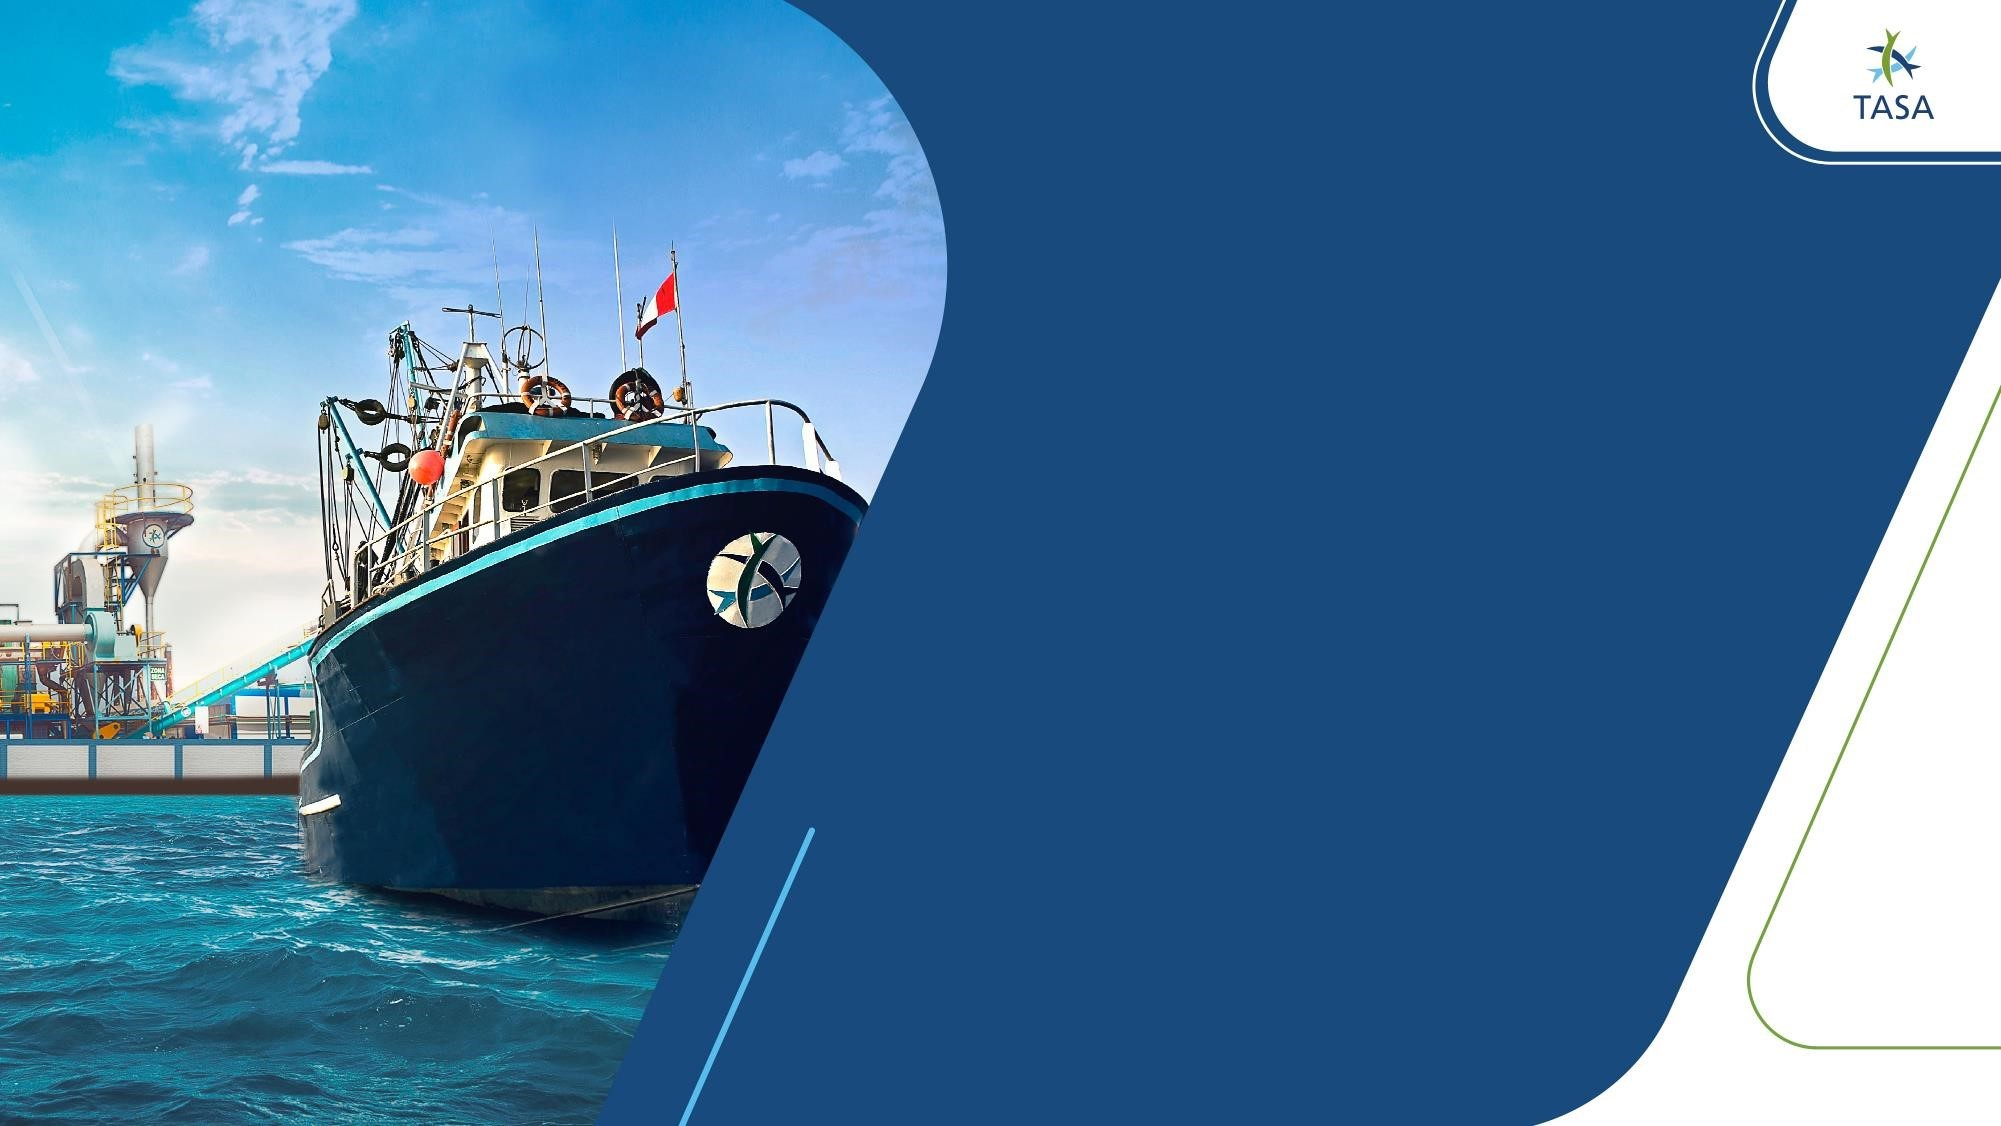

## EVALUACIÓN DE KPIS - PROCESO ACODERA A INICIO_SUCCION

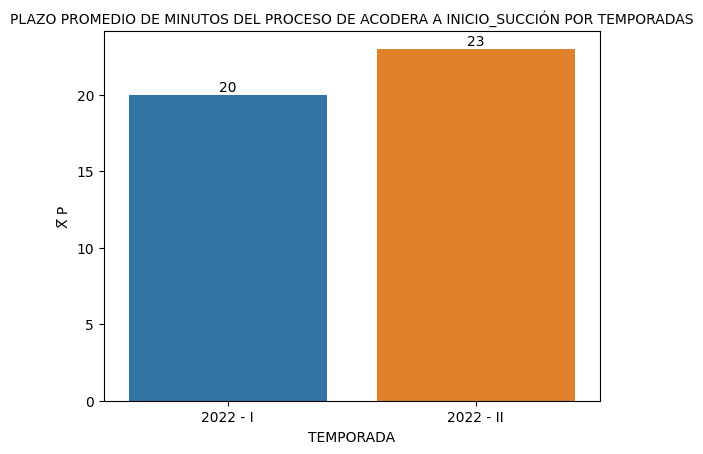

In [5]:
df1 = df_tasa[['PLANTA','TEMPORADA','ACODERA','INICIO_SUCCION']]
df1['P'] = (df1['INICIO_SUCCION'] - df1['ACODERA'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'P':'mean'})
df1.rename(columns = {'P':'X̅ P'}, inplace = True)
df1['X̅ P'] = df1['X̅ P'].round()
df1 = df1.sort_index()

barplot_df('TEMPORADA','X̅ P',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE ACODERA A INICIO_SUCCIÓN POR TEMPORADAS')

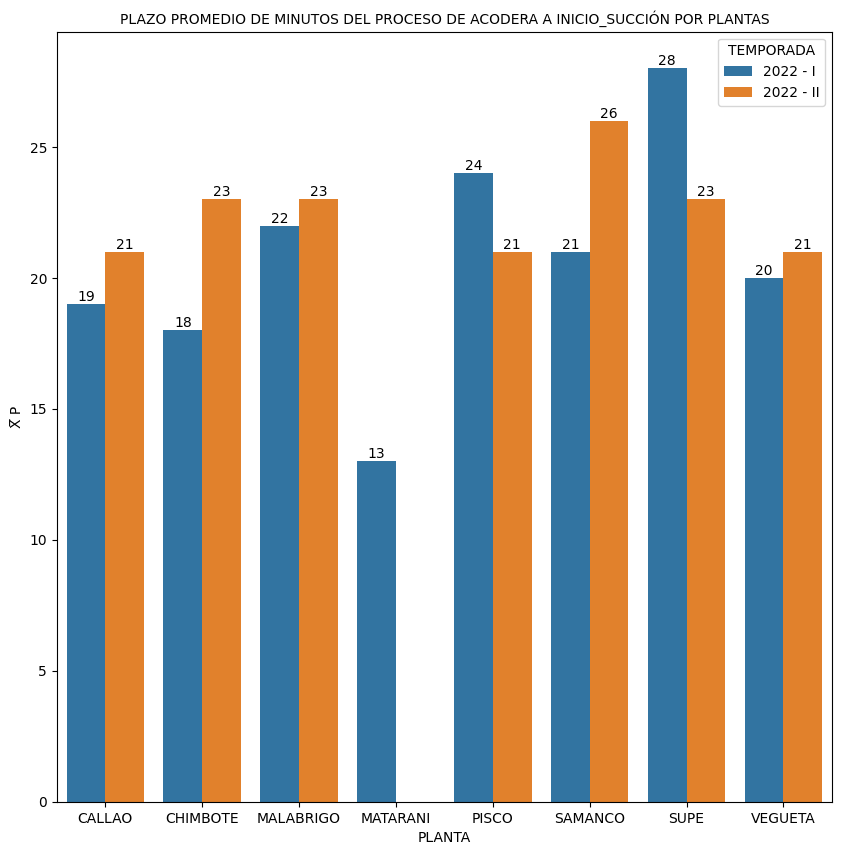

In [6]:
df1 = df_tasa[['PLANTA','TEMPORADA','ACODERA','INICIO_SUCCION']]
df1['P'] = (df1['INICIO_SUCCION'] - df1['ACODERA'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'P':'mean'})
df1.rename(columns = {'P':'X̅ P'}, inplace = True)
df1['X̅ P'] = df1['X̅ P'].round()
df1 = df1.sort_index()

barplot_df_hue('PLANTA','X̅ P','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE ACODERA A INICIO_SUCCIÓN POR PLANTAS')

## EVALUACIÓN DE LOS TIEMPOS DE INICIO_SUCCION CON INICIO_DESCARGA

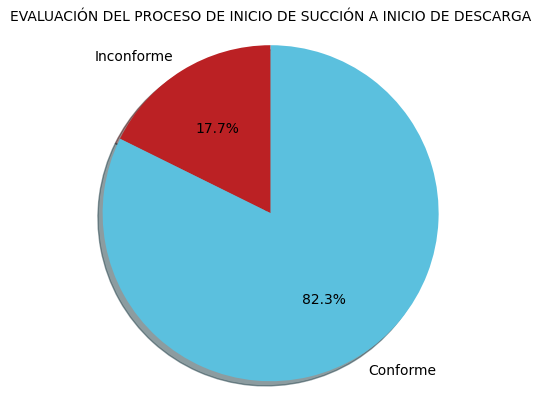

In [7]:
df_tasa['INISUCCION_INIDESCARGA_CORRECTO'] = np.where(df_tasa['INICIO_DESCARGA'] < df_tasa['INICIO_SUCCION'],0,1)
df_tasa['INISUCCION_INIDESCARGA_MIN'] = (df_tasa['INICIO_DESCARGA'] - df_tasa['INICIO_SUCCION'] ).dt.total_seconds() / 60.0

piechart_percentage(values_total('INISUCCION_INIDESCARGA_CORRECTO',df_tasa),'EVALUACIÓN DEL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA')

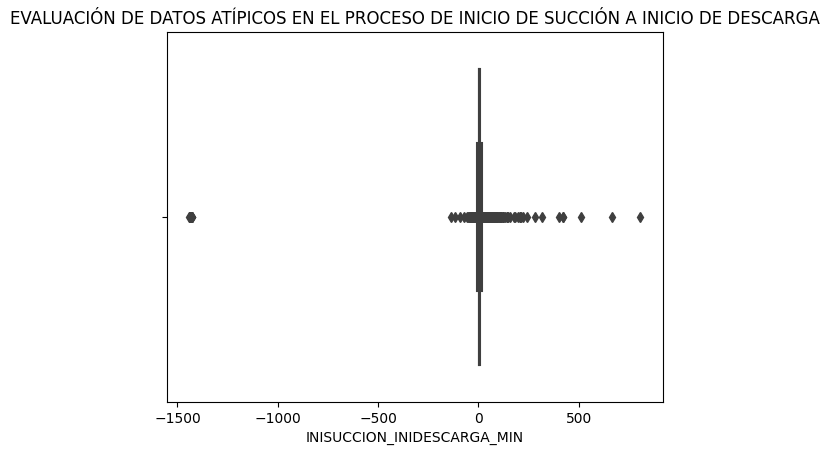

In [8]:
boxplot_df(df_tasa,'INISUCCION_INIDESCARGA_MIN','EVALUACIÓN DE DATOS ATÍPICOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA')

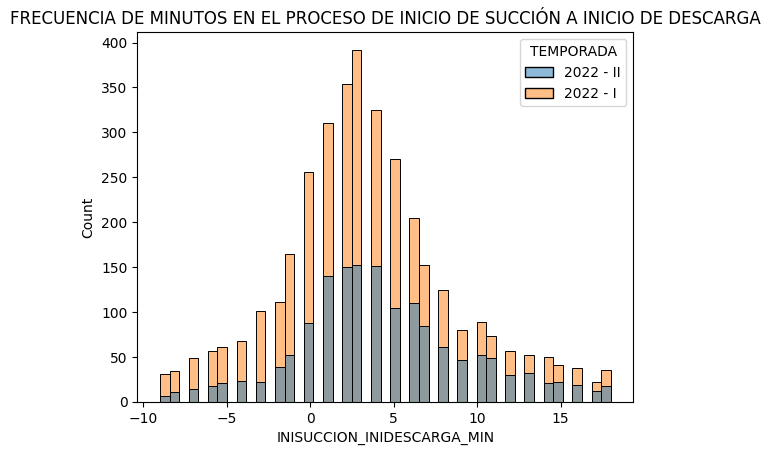

In [9]:
LTV,UTV = select_values_outliers(df_tasa['INISUCCION_INIDESCARGA_MIN'].to_frame())
df_tasa['ATIPICO_INISUCCION_INIDESCARGA'] = np.where((df_tasa['INISUCCION_INIDESCARGA_MIN'] < LTV) | (df_tasa['INISUCCION_INIDESCARGA_MIN'] > UTV),1,0)

histplot_df_hue(df_tasa[df_tasa['ATIPICO_INISUCCION_INIDESCARGA']==0],'INISUCCION_INIDESCARGA_MIN','TEMPORADA','FRECUENCIA DE MINUTOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA')

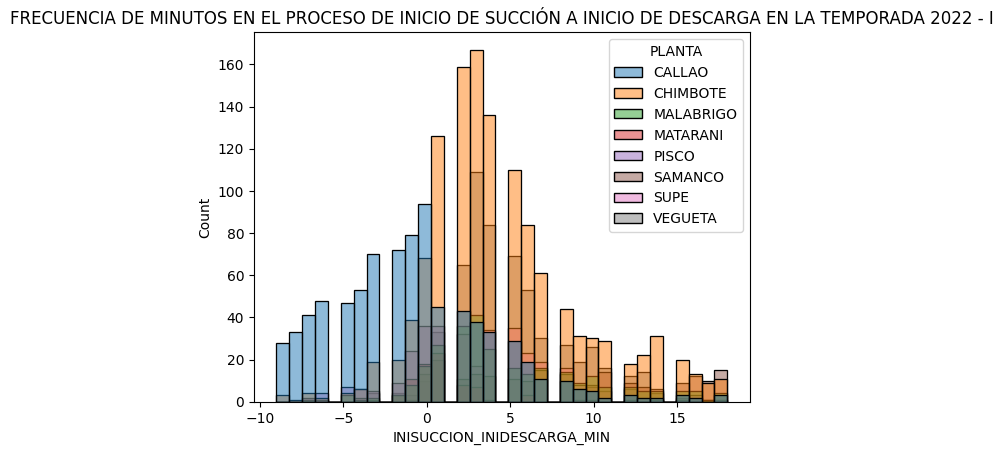

In [10]:
histplot_df_hue(df_tasa[ (df_tasa['ATIPICO_INISUCCION_INIDESCARGA']==0) & (df_tasa['TEMPORADA'] == '2022 - I')].sort_values(by='PLANTA'),'INISUCCION_INIDESCARGA_MIN','PLANTA','FRECUENCIA DE MINUTOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA EN LA TEMPORADA 2022 - I')

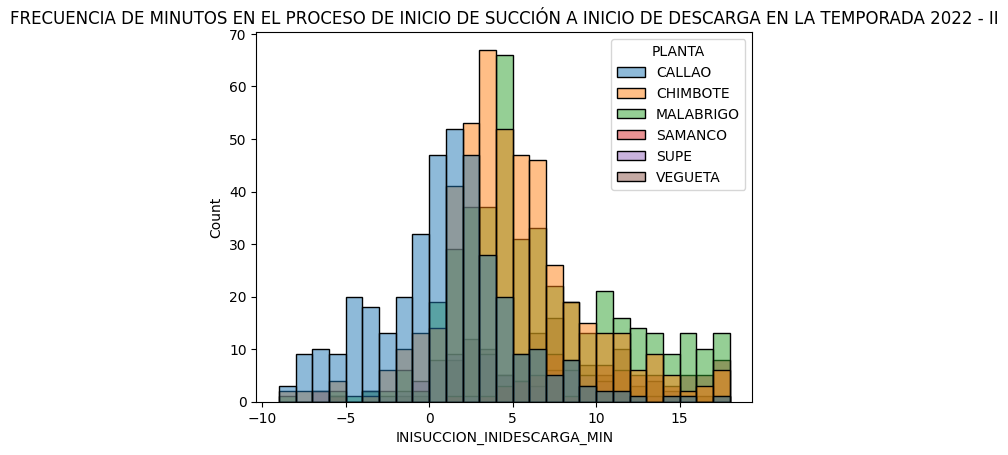

In [11]:
histplot_df_hue(df_tasa[ (df_tasa['ATIPICO_INISUCCION_INIDESCARGA']==0) & (df_tasa['TEMPORADA'] == '2022 - II')].sort_values(by='PLANTA'),'INISUCCION_INIDESCARGA_MIN','PLANTA','FRECUENCIA DE MINUTOS EN EL PROCESO DE INICIO DE SUCCIÓN A INICIO DE DESCARGA EN LA TEMPORADA 2022 - II')

 ## EVALUACIÓN DE KPIS =  FIN DE ANÁLISIS A INICIO DE SUCCIÓN

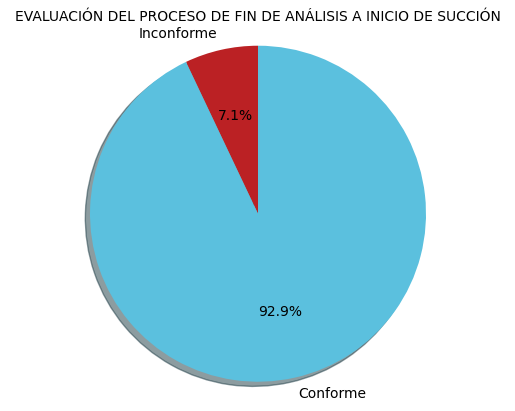

In [12]:
df_tasa2 = df_tasa[~df_tasa['INICIO_ANALISIS'].isnull()]
df_tasa2 = df_tasa2[df_tasa2['ATIPICO_INISUCCION_INIDESCARGA']==0]

df_tasa2['FINANALISIS_INISUCCION_CORRECTO'] = np.where(df_tasa2['FIN_ANALISIS'] > df_tasa2['INICIO_SUCCION'],0,1) 
df_tasa2['FINANALISIS_INISUCCION_MIN'] = (df_tasa2['INICIO_SUCCION'] - df_tasa2['FIN_ANALISIS'] ).dt.total_seconds() / 60.0

piechart_percentage(values_total('FINANALISIS_INISUCCION_CORRECTO',df_tasa2),'EVALUACIÓN DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN')

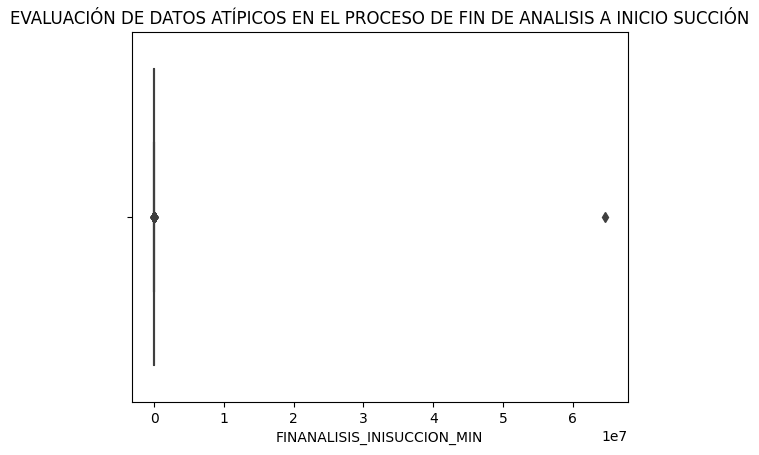

In [13]:
boxplot_df(df_tasa2,'FINANALISIS_INISUCCION_MIN','EVALUACIÓN DE DATOS ATÍPICOS EN EL PROCESO DE FIN DE ANALISIS A INICIO SUCCIÓN')

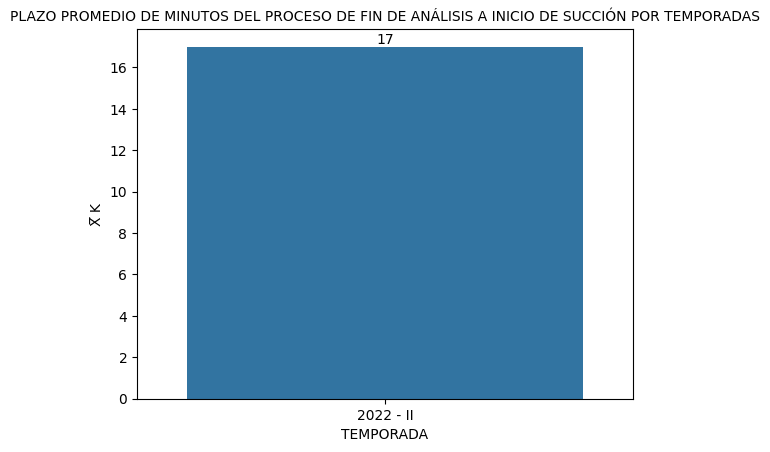

In [14]:
LTV,UTV = select_values_outliers(df_tasa2['FINANALISIS_INISUCCION_MIN'].to_frame())
df_tasa2['ATIPICO_FINANALISIS_INISUCCION'] = np.where((df_tasa2['FINANALISIS_INISUCCION_MIN'] < LTV) | (df_tasa2['FINANALISIS_INISUCCION_MIN'] > UTV),1,0)

df1 = df_tasa2[df_tasa2['ATIPICO_FINANALISIS_INISUCCION'] == 0][['TEMPORADA','PLANTA','FIN_ANALISIS','INICIO_SUCCION']]
df1['K'] = (df1['INICIO_SUCCION'] - df1['FIN_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = df1['X̅ K'].round()
df1 = df1.sort_index()

barplot_df('TEMPORADA','X̅ K',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN POR TEMPORADAS')

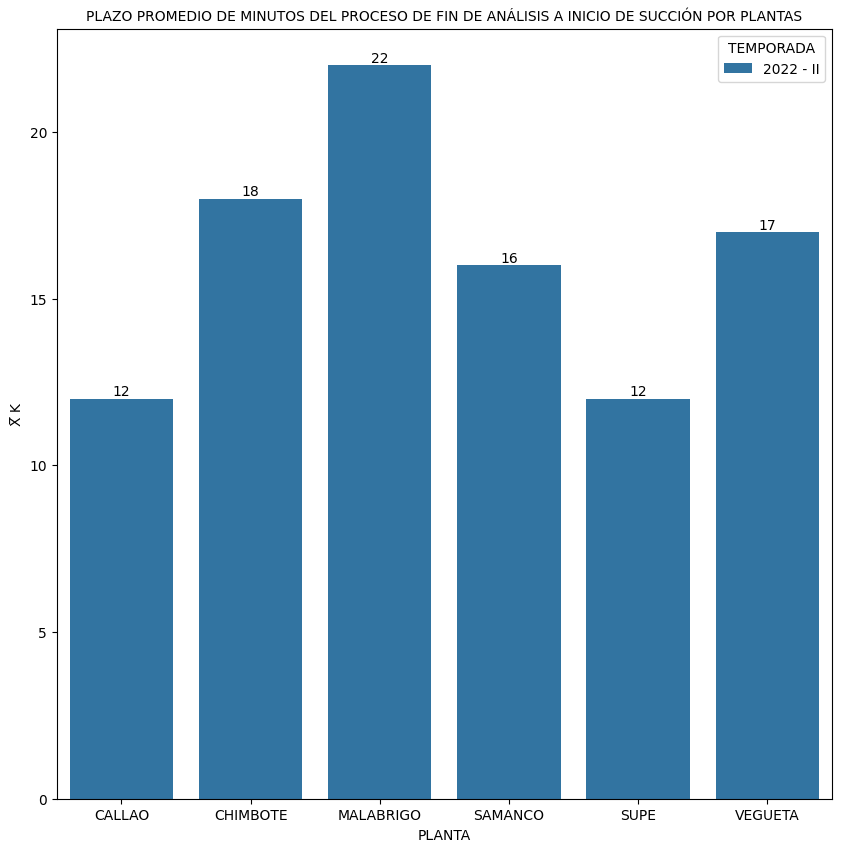

In [15]:
df1 = df_tasa2[df_tasa2['ATIPICO_FINANALISIS_INISUCCION'] == 0][['PLANTA','TEMPORADA','FIN_ANALISIS','INICIO_SUCCION']]
df1['K'] = (df1['INICIO_SUCCION'] - df1['FIN_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'K':'mean'})
df1.rename(columns = {'K':'X̅ K'}, inplace = True)
df1['X̅ K'] = df1['X̅ K'].round()
df1 = df1.sort_index()

barplot_df_hue('PLANTA','X̅ K','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE FIN DE ANÁLISIS A INICIO DE SUCCIÓN POR PLANTAS')

## EVALUACIÓN DE KPIS - PROCESO INICIO ANALISIS A INICIO SUCCION

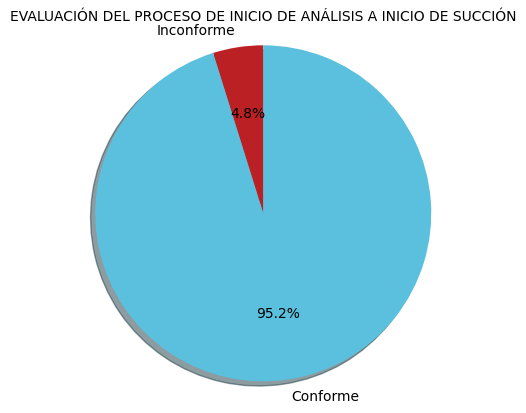

In [16]:
df_tasa2 = df_tasa[~df_tasa['INICIO_ANALISIS'].isnull()]
df_tasa2 = df_tasa2[df_tasa2['ATIPICO_INISUCCION_INIDESCARGA']==0]

df_tasa2['INIANALISIS_INISUCCION_CORRECTO'] = np.where(df_tasa2['INICIO_ANALISIS'] > df_tasa2['INICIO_SUCCION'],0,1) 
df_tasa2['INIANALISIS_INISUCCION_MIN'] = (df_tasa2['INICIO_SUCCION'] - df_tasa2['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0

piechart_percentage(values_total('INIANALISIS_INISUCCION_CORRECTO',df_tasa2),'EVALUACIÓN DEL PROCESO DE INICIO DE ANÁLISIS A INICIO DE SUCCIÓN')

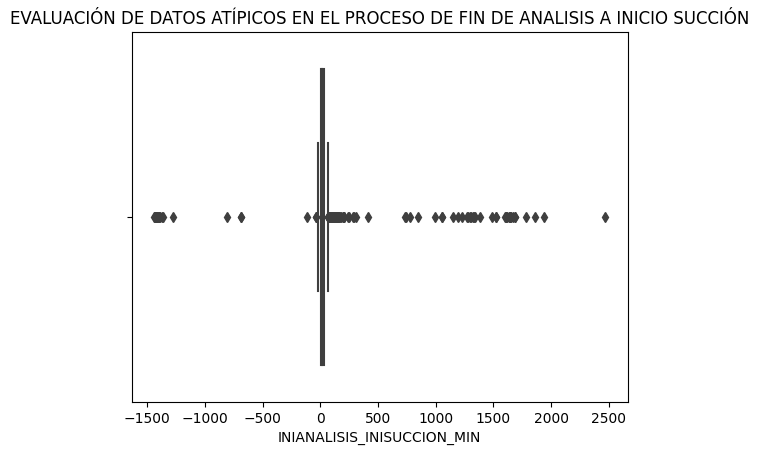

In [17]:
boxplot_df(df_tasa2,'INIANALISIS_INISUCCION_MIN','EVALUACIÓN DE DATOS ATÍPICOS EN EL PROCESO DE FIN DE ANALISIS A INICIO SUCCIÓN')

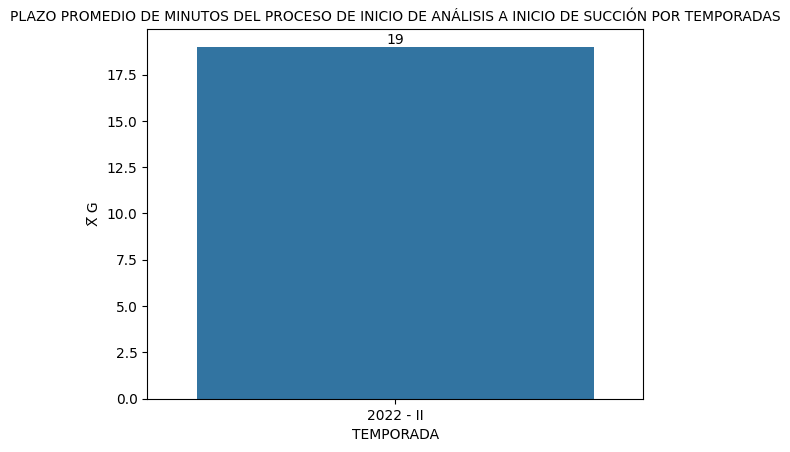

In [18]:
LTV,UTV = select_values_outliers(df_tasa2['INIANALISIS_INISUCCION_MIN'].to_frame())
df_tasa2['ATIPICO_INIANALISIS_INISUCCION'] = np.where((df_tasa2['INIANALISIS_INISUCCION_MIN'] < LTV) | (df_tasa2['INIANALISIS_INISUCCION_MIN'] > UTV),1,0)

df1 = df_tasa2[df_tasa2['ATIPICO_INIANALISIS_INISUCCION'] == 0][['TEMPORADA','PLANTA','INICIO_ANALISIS','INICIO_SUCCION']]
df1['G'] = (df1['INICIO_SUCCION'] - df1['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA'],as_index=False).agg({'G':'mean'})
df1.rename(columns = {'G':'X̅ G'}, inplace = True)
df1['X̅ G'] = df1['X̅ G'].round()
df1 = df1.sort_index()

barplot_df('TEMPORADA','X̅ G',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE ANÁLISIS A INICIO DE SUCCIÓN POR TEMPORADAS')

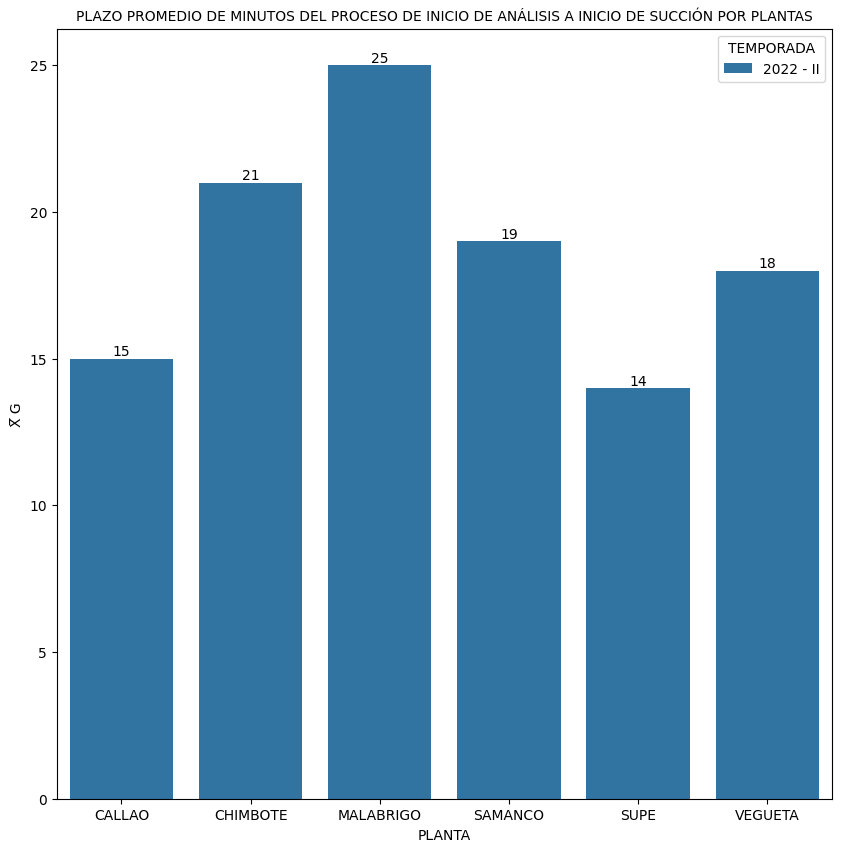

In [19]:
df1 = df_tasa2[df_tasa2['ATIPICO_INIANALISIS_INISUCCION'] == 0][['PLANTA','TEMPORADA','INICIO_ANALISIS','INICIO_SUCCION']]
df1['G'] = (df1['INICIO_SUCCION'] - df1['INICIO_ANALISIS'] ).dt.total_seconds() / 60.0
df1 = df1.groupby(['TEMPORADA','PLANTA'],as_index=False).agg({'G':'mean'})
df1.rename(columns = {'G':'X̅ G'}, inplace = True)
df1['X̅ G'] = df1['X̅ G'].round()
df1 = df1.sort_index()

barplot_df_hue('PLANTA','X̅ G','TEMPORADA',df1,'PLAZO PROMEDIO DE MINUTOS DEL PROCESO DE INICIO DE ANÁLISIS A INICIO DE SUCCIÓN POR PLANTAS')